<a href="https://colab.research.google.com/github/zhaooao/ai./blob/main/bias_variance_underfitting_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 偏差-方差权衡 與 欠擬合/過擬合 的關係 (Bias-Variance tradeoff, Underfitting vs Overfitting)


為了最小化預期誤差，我們需要選擇一種能夠同時實現**低方差** (low bias) 和**低偏差** (low variance) 的學習演算法。

然而，明確計算偏差和變異數通常很困難，有時甚至不可能。另一個複雜之處在於，**最優模型通常取決於訓練資料的大小**。因此，我們依靠兩條重要的曲線來幫助我們確定理想的「最佳」模型：

1. 我們使用**驗證曲線**來探索模型的偏差和方差，該偏差和方差是固定數量訓練資料下*模型複雜度*的函數。
2. 我們使用**學習曲線**來探索固定模型的偏差和方差，該偏差和方差是*訓練集大小*的函數。

### 驗證曲線 (validation curve)

**驗證曲線**描繪了在固定訓練次數下，模型複雜度（例如多項式的次數、神經元/層的數量、迭代次數（epoch）等）對訓練分數和驗證分數的影響。

- 簡單模型在驗證集上的表現與在訓練集上的表現相似。(underfitting)
- 複雜模型在驗證集上的表現遠低於在訓練集上的表現。(overfitting)

最佳模型（bias-variance 之間的平衡）是驗證分數的峰值。

讓我們來看一個使用交叉驗證來計算一類模型的驗證曲線的範例。

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

現在讓我們創建一些適合我們模型的數據：

In [ ]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

現在我們可以將資料與多階多項式擬合視覺化：

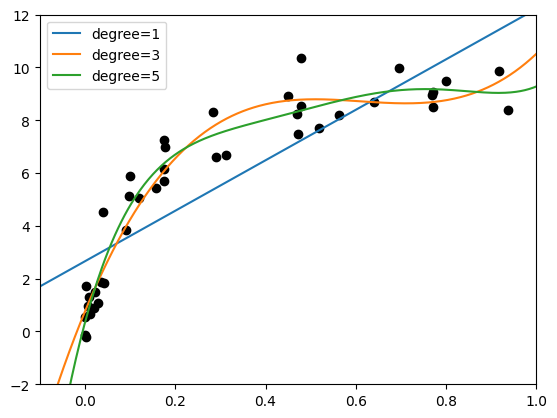

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]: # model complexity
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best')

在這種情況下，控制模型複雜度的旋鈕是多項式的次數 (degree of polynomial)，它可以是任何非負整數。一個有用的問題是：什麼次數的多項式能夠在偏差（欠擬合）和方差（過度擬合）之間提供合適的權衡？

我們可以透過視覺化特定資料和模型的驗證曲線來取得進展；這可以直接使用 Scikit-Learn 提供的 validation_curve 函數來實現。給定模型、資料、參數名稱和要探索的範圍，此函數將自動計算該範圍內的訓練分數和驗證分數：

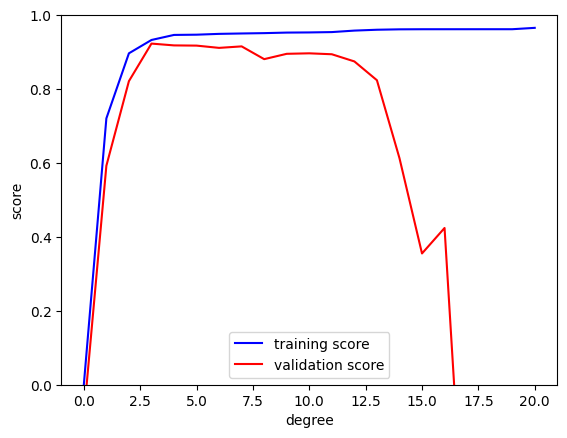

In [ ]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y, param_name='polynomialfeatures__degree', param_range=degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

這正好體現了我們預期的行為。我們預期什麼？

1. 如果訓練分數和驗證分數都很低，則估計器將處於欠擬合狀態。如果訓練分數很高而驗證分數很低，則估計器將處於過度擬合狀態。
2. 訓練分數處處高於驗證分數。
3. 隨著模型複雜度的增加，訓練分數單調遞增。
4. 驗證分數達到最大值，然後隨著模型過度擬合而下降。
5. 對於三階多項式，找到了偏差和變異數之間最適平衡的最佳模型。

從驗證曲線中，我們可以讀出，偏差和變異數之間的最佳權衡是三階多項式；我們可以如下計算並顯示原始資料的擬合結果：

(np.float64(-0.04687651021505175),
 np.float64(0.9844070023112612),
 np.float64(-0.7308177116555796),
 np.float64(10.902869392322714))

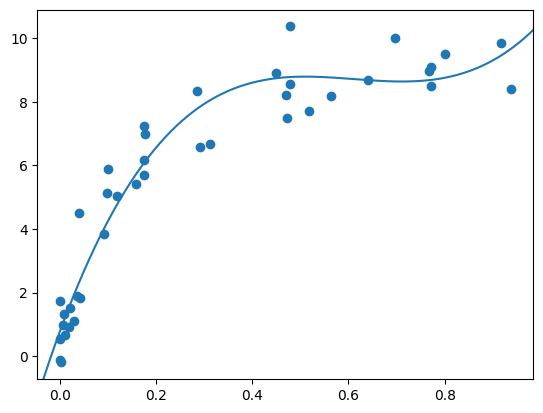

In [ ]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test)
plt.axis(lim)

### 學習曲線 (learning curve)

模型複雜性的一個重要方面是，**最佳模型通常取決於訓練資料的大小**。例如，讓我們產生一個新的資料集，其點數增加五倍（從 40 到 200）：

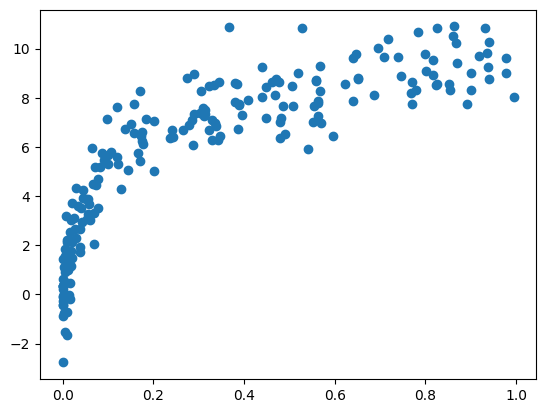

In [ ]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2)

我們將複製前面的程式碼來繪製這個更大資料集的驗證曲線；作為參考，我們也繪製一下先前的結果：

Text(0, 0.5, 'score')

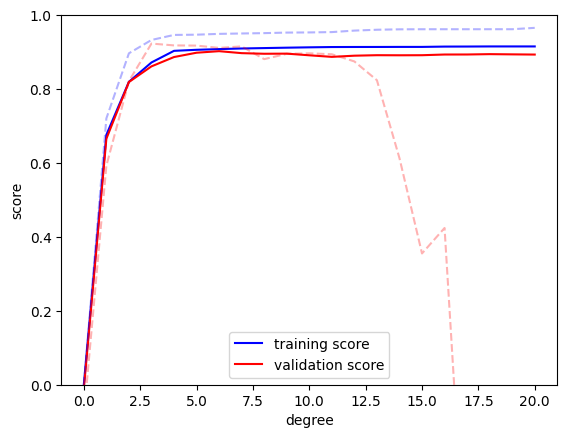

In [ ]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2, param_name='polynomialfeatures__degree', param_range=degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score')

實線表示新的結果，而較淺的虛線表示先前較小資料集的結果。從驗證曲線可以清楚看出，**較大的資料集可以支援更複雜的模型**：這裡的峰值可能在6階左右，但即使是20階的模型也不會嚴重過度擬合資料——驗證分數和訓練分數仍然非常接近。

因此，我們看到驗證曲線的行為有兩個重要的輸入：**模型複雜度**和**訓練集的大小**。探索*模型行為與訓練集大小的關係*通常很有用，我們可以透過使用越來越大的資料子集來擬合我們的模型來實現這一點。訓練/驗證分數與訓練集大小的關係圖稱為**學習曲線**。

我們預期學習曲線的一般行為是這樣的：
- 固定複雜度的模型會對小型資料集產生過擬合：這表示訓練分數相對較高，而驗證分數相對較低。
- 固定複雜度的模型會對大型資料集產生欠擬合：這表示訓練分數會下降，但驗證分數會上升。
- 除非偶然，否則模型在驗證集上的得分永遠不會高於訓練集：這意味著曲線應該越來越接近，但永遠不會交叉。

學習曲線的一個顯著特徵是，隨著訓練樣本數量的增加，它會收斂到特定的分數。特別是，一旦你擁有足夠的樣本點，某個模型已經收斂，那麼添加更多的訓練資料對你來說就沒有任何幫助了！在這種情況下，提升模型效能的唯一方法是使用更複雜的模型。

Scikit-Learn 提供了一個方便的工具，可以從您的模型中計算此類學習曲線；在這裡，我們將使用二階多項式模型和九階多項式計算原始資料集的學習曲線：

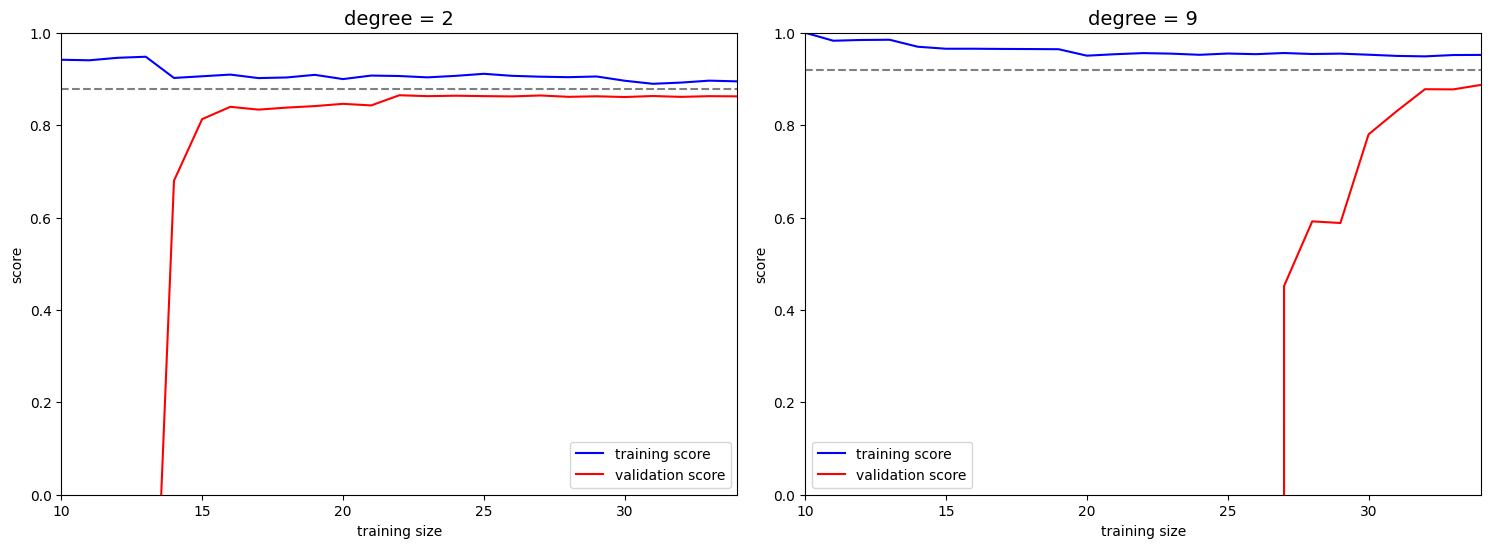

In [ ]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

Q：從二階模型的學習曲線中，你了解到什麼？

A：
當你的學習曲線已經收斂時（即訓練曲線和驗證曲線已經彼此接近），增加更多訓練資料並不能顯著改善擬合度！這種情況在左側面板中可以看到，其中顯示了二階模型的學習曲線。


Q：從九階模型的學習曲線中，你了解到什麼？

A：
透過轉向更複雜的模型，我們提高了收斂分數（由虛線表示），但代價是模型 variance 更大（由訓練分數和驗證分數之間的差異表示）。如果我們增加更多數據點，更複雜模型的學習曲線最終會收斂。